In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')

# Data Cleaning - Handling NaN Values
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

print(train.head(), train.shape, train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7552408 entries, 0 to 7552407
Data columns (total 20 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ID           object 
 1   time         object 
 2   Green        float64
 3   Blue         float64
 4   RED          float64
 5   NIR          float64
 6   SWIR1        float64
 7   SWIR2        float64
 8   Red_Edge     float64
 9   Aerosols     float64
 10  Red_Edge_2   float64
 11  Red_Edge_3   float64
 12  Red_Edge_4   float64
 13  Water_vapor  float64
 14  Cirrus       float64
 15  NDVI         float64
 16  NDMI         float64
 17  NDWI         float64
 18  CI           float64
 19  Target       float64
dtypes: float64(18), object(2)
memory usage: 1.1+ GB
        ID        time   Green    Blue     RED     NIR   SWIR1   SWIR2  \
0  1D_0000  2021-01-04  0.1670  0.1823  0.1515  0.3361  0.2228  0.1337   
1  1D_0000  2021-01-09  0.1670  0.1823  0.1515  0.3361  0.2228  0.1337   
2  1D_0000  2021-01-14  0.0845  0.1030  

In [3]:
train.isnull().sum()

,0
ID,0
time,0
Green,0
Blue,0
RED,0
NIR,0
SWIR1,0
SWIR2,0
Red_Edge,0
Aerosols,0


In [4]:
print(test.head(), test.shape, test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946879 entries, 0 to 4946878
Data columns (total 19 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ID           object 
 1   time         object 
 2   Green        float64
 3   Blue         float64
 4   RED          float64
 5   NIR          float64
 6   SWIR1        float64
 7   SWIR2        float64
 8   Red_Edge     float64
 9   Aerosols     float64
 10  Red_Edge_2   float64
 11  Red_Edge_3   float64
 12  Red_Edge_4   float64
 13  Water_vapor  float64
 14  Cirrus       float64
 15  NDVI         float64
 16  NDMI         float64
 17  NDWI         float64
 18  CI           float64
dtypes: float64(17), object(2)
memory usage: 717.1+ MB
        ID        time   Green    Blue     RED     NIR   SWIR1   SWIR2  \
0  1D_0005  2021-01-04  0.1199  0.1391  0.0978  0.2329  0.1782  0.0989   
1  1D_0005  2021-01-09  0.1666  0.1818  0.1508  0.3372  0.2221  0.1328   
2  1D_0005  2021-01-14  0.0818  0.1010  0.0563  0.1848  0.1139  

In [5]:
test.isnull().sum()

,0
ID,0
time,0
Green,0
Blue,0
RED,0
NIR,0
SWIR1,0
SWIR2,0
Red_Edge,0
Aerosols,0


In [6]:
sub = pd.read_csv('/content/SampleSubmission (2).csv')
print(sub.head(), sub.shape, sub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      16960 non-null  object
 1   Target  16960 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 265.1+ KB
        ID  Target
0  1D_0005       0
1  1D_000A       0
2  1D_000D       0
3  1D_000E       0
4  1D_0015       0 (16960, 2) None


In [7]:
# Extract Features and Target
features = [col for col in train.columns if col not in ['ID', 'Target']]
target = 'Target'

X = train[features]
y = train[target]
X_test = test[features]

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
import pandas as pd

# Convert 'time' to datetime format
X_train['time'] = pd.to_datetime(X_train['time'])
X_val['time'] = pd.to_datetime(X_val['time'])

# Extract features from datetime
X_train['day_of_year'] = X_train['time'].dt.dayofyear
X_train['month'] = X_train['time'].dt.month
X_train['week'] = X_train['time'].dt.isocalendar().week

X_val['day_of_year'] = X_val['time'].dt.dayofyear
X_val['month'] = X_val['time'].dt.month
X_val['week'] = X_val['time'].dt.isocalendar().week

# Drop the original 'time' column
X_train = X_train.drop(columns=['time'])
X_val = X_val.drop(columns=['time'])



In [8]:
!pip show lightgbm


Name: lightgbm
Version: 4.6.0
Summary: LightGBM Python-package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (MIT)

Copyright (c) Microsoft Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS O

In [9]:
!pip install --upgrade lightgbm


In [10]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score, classification_report

# LightGBM Model Parameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': 100
}

d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val, reference=d_train)

# Train Model using Callbacks
model = lgb.train(
    params,
    d_train,
    valid_sets=[d_val],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]  # Early stopping and logging
)

# Predict on Validation Set
y_val_pred = np.argmax(model.predict(X_val), axis=1)

# Evaluate Performance
print("Validation F1 Score:", f1_score(y_val, y_val_pred, average='macro'))
print(classification_report(y_val, y_val_pred))


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000052
[LightGBM] [Debug] init for col-wise cost 0.000147 seconds, init for row-wise cost 1.792358 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.526758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4622
[LightGBM] [Info] Number of data points in the train set: 6041926, number of used features: 20
[LightGBM] [Info] Start training from score -0.768248
[LightGBM] [Info] Start training from score -1.597523
[LightGBM] [Info] Start training from score -1.097280
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
Training until validation scores don't improve for 50 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 

<Figure size 1000x600 with 0 Axes>

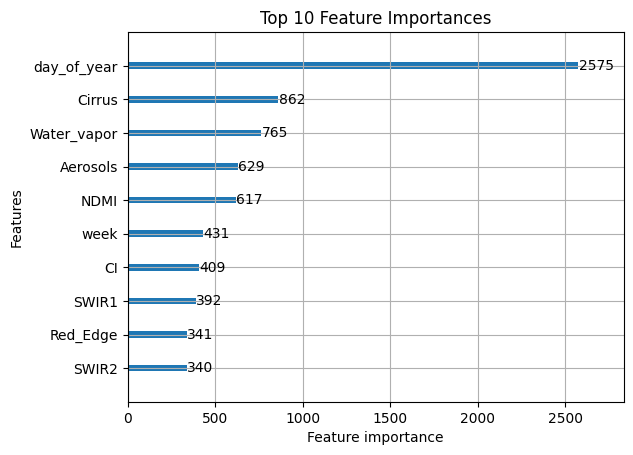

In [11]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


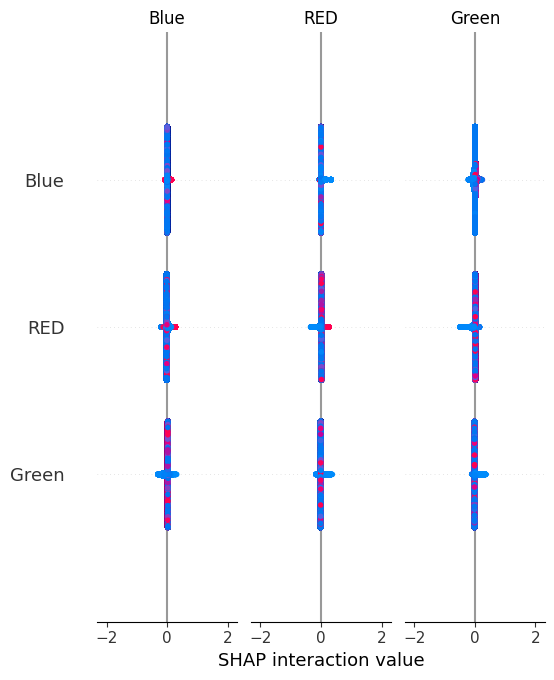

In [32]:
# SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)


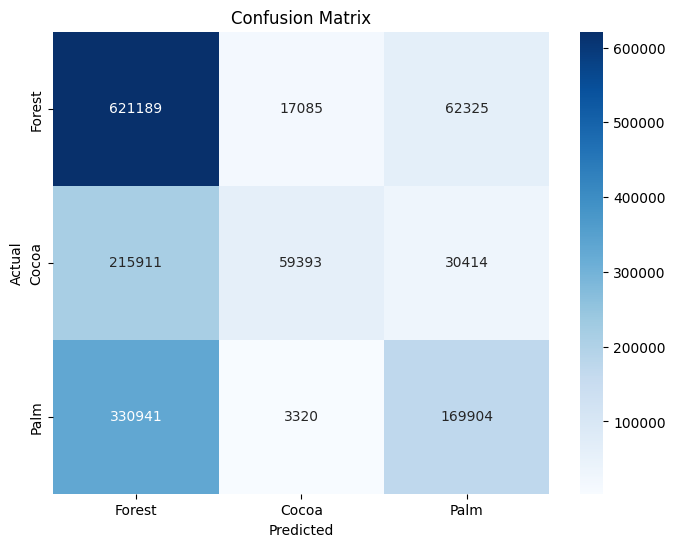

In [12]:
# Confusion Matrix Plot
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forest', 'Cocoa', 'Palm'], yticklabels=['Forest', 'Cocoa', 'Palm'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
import numpy as np
import pandas as pd

# Ensure test dataset has same columns as train
for col in X_train.columns:
    if col not in test.columns:
        test[col] = 0  # Assign default value (e.g., 0 or test[col].mean())

X_test = test[X_train.columns]  # Now test has the same features

# Predict on Test Set
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# Ensure 'ID' column exists
if 'ID' not in test.columns:
    raise ValueError("The 'ID' column is missing in the test dataset.")

# Create submission file
submission = pd.DataFrame({'ID': test['ID'], 'Target': y_test_pred})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")


Submission file saved as submission.csv


In [16]:
sub1 = pd.read_csv('/content/submission.csv')
print(sub1.head(), sub1.shape, sub1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946879 entries, 0 to 4946878
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   Target  int64 
dtypes: int64(1), object(1)
memory usage: 75.5+ MB
        ID  Target
0  1D_0005       0
1  1D_0005       0
2  1D_0005       0
3  1D_0005       0
4  1D_0005       0 (4946879, 2) None


In [17]:
sub1.isnull().sum()

,0
ID,0
Target,0
